In [116]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, roc_curve, confusion_matrix

%config InlineBackend.figure_format = 'png'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

## Data Loading ##

In [48]:
with open('cleaned_sample_df.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [172]:
with open('feature_engineering_sample_df.pickle', 'wb') as to_write:
    pickle.dump(sample_df, to_write)

In [49]:
sample_df.shape

(100000, 42)

In [50]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   object 
 12  taxi_out                       

In [147]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0
1,2015,6,21,7,WN,511,N7714B,DEN,CMH,1835,1831,-4.0,11.0,1842,165,157.0,140.0,1154,2302,6.0,2320,2308,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Denver International Airport,Denver,CO,39.86,-104.67,Port Columbus International Airport,Columbus,OH,40.00,-82.89,0
2,2015,2,18,3,AA,1271,N3ESAA,SNA,DFW,1217,1210,-7.0,12.0,1222,168,168.0,139.0,1205,1641,17.0,1705,1658,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,John Wayne Airport (Orange County Airport),Santa Ana,CA,33.68,-117.87,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04,0
3,2015,8,26,3,DL,1925,N963DN,ATL,BWI,0730,0729,-1.0,16.0,0745,110,104.0,81.0,577,0906,7.0,0920,0913,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0
4,2015,6,1,1,WN,3301,N793SA,SAT,DAL,1250,1244,-6.0,11.0,1255,60,64.0,48.0,248,1343,5.0,1350,1348,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Dallas Love Field,Dallas,TX,32.85,-96.85,0


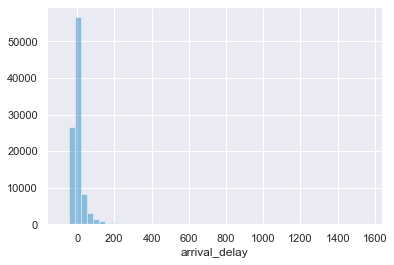

In [52]:
sns.distplot(sample_df['arrival_delay'], kde=False)

## Data Cleaning ##

In [53]:
sample_df.columns

Index(['year', 'month', 'day', 'day_of_week', 'airline', 'flight_number',
       'tail_number', 'origin_airport', 'destination_airport',
       'scheduled_departure', 'departure_time', 'departure_delay', 'taxi_out',
       'wheels_off', 'scheduled_time', 'elapsed_time', 'air_time', 'distance',
       'wheels_on', 'taxi_in', 'scheduled_arrival', 'arrival_time',
       'arrival_delay', 'diverted', 'cancelled', 'cancellation_reason',
       'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft',
       'weather_delay', 'airline_name', 'origin_airport_name',
       'origin_airport_city', 'origin_airport_state',
       'origin_airport_latitude', 'origin_airport_longitude',
       'destination_airport_name', 'destination_airport_city',
       'destination_airport_state', 'destination_airport_latitude',
       'destination_airport_longitude'],
      dtype='object')

In [68]:
numeric_cols = ['departure_delay', 'taxi_out', 'scheduled_time', 'elapsed_time',
                'air_time', 'distance', 'taxi_in', 'arrival_delay', 
                'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft', 'weather_delay']

In [69]:
len(numeric_cols)

13

In [66]:
# Step 1
sample_df[numeric_cols] = sample_df[numeric_cols].apply(pd.to_numeric, errors='ignore')

In [70]:
sample_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   float64
 12  taxi_out                       

In [71]:
sample_df.describe()

,year,month,day,day_of_week,flight_number,departure_delay,taxi_out,scheduled_time,elapsed_time,air_time,distance,taxi_in,arrival_delay,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,origin_airport_latitude,origin_airport_longitude,destination_airport_latitude,destination_airport_longitude
count,100000.0,100000.00,100000.00,100000.00,100000.00,98518.00,98468.00,100000.00,98166.00,98166.00,100000.0,98403.00,98166.00,1.00e+05,100000.00,18293.00,18293.00,18293.00,18293.00,18293.00,91592.00,91592.00,91591.00,91591.00
mean,2015.0,6.54,15.72,3.92,2172.38,9.51,16.10,142.13,137.43,113.91,825.7,7.44,4.55,2.85e-03,0.02,13.76,0.10,19.38,23.86,2.90,36.63,-95.49,36.66,-95.46
std,0.0,3.40,8.79,1.99,1759.44,38.33,9.01,75.21,74.12,72.15,607.4,5.67,40.58,5.33e-02,0.12,27.93,2.57,51.37,43.86,21.02,6.00,18.10,5.98,18.10
min,2015.0,1.00,1.00,1.00,1.00,-35.00,1.00,20.00,18.00,9.00,31.0,1.00,-78.00,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,13.48,-176.65,13.48,-176.65
25%,2015.0,4.00,8.00,2.00,733.00,-5.00,11.00,86.00,82.00,61.00,373.0,4.00,-13.00,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,32.90,-111.98,32.90,-111.98
50%,2015.0,7.00,16.00,4.00,1683.00,-2.00,14.00,123.00,119.00,95.00,651.0,6.00,-5.00,0.00e+00,0.00,2.00,0.00,2.00,3.00,0.00,37.36,-90.26,37.36,-90.26
75%,2015.0,9.00,23.00,6.00,3226.00,7.00,19.00,174.00,169.00,144.00,1067.0,9.00,8.00,0.00e+00,0.00,18.00,0.00,19.00,30.00,0.00,40.79,-81.69,40.79,-81.53
max,2015.0,12.00,31.00,7.00,7438.00,1576.00,154.00,680.00,691.00,645.00,4983.0,177.00,1557.00,1.00e+00,1.00,488.00,181.00,1557.00,790.00,1002.00,71.29,-64.80,71.29,-64.80


In [72]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68
1,2015,6,21,7,WN,511,N7714B,DEN,CMH,1835,1831,-4.0,11.0,1842,165,157.0,140.0,1154,2302,6.0,2320,2308,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Denver International Airport,Denver,CO,39.86,-104.67,Port Columbus International Airport,Columbus,OH,40.00,-82.89
2,2015,2,18,3,AA,1271,N3ESAA,SNA,DFW,1217,1210,-7.0,12.0,1222,168,168.0,139.0,1205,1641,17.0,1705,1658,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,John Wayne Airport (Orange County Airport),Santa Ana,CA,33.68,-117.87,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04
3,2015,8,26,3,DL,1925,N963DN,ATL,BWI,0730,0729,-1.0,16.0,0745,110,104.0,81.0,577,0906,7.0,0920,0913,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67
4,2015,6,1,1,WN,3301,N793SA,SAT,DAL,1250,1244,-6.0,11.0,1255,60,64.0,48.0,248,1343,5.0,1350,1348,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Dallas Love Field,Dallas,TX,32.85,-96.85


In [73]:
sample_df[sample_df['arrival_delay'] > 20].count()

year                             14822
month                            14822
day                              14822
day_of_week                      14822
airline                          14822
flight_number                    14822
tail_number                      14822
origin_airport                   14822
destination_airport              14822
scheduled_departure              14822
departure_time                   14822
departure_delay                  14822
taxi_out                         14822
wheels_off                       14822
scheduled_time                   14822
elapsed_time                     14822
air_time                         14822
distance                         14822
wheels_on                        14822
taxi_in                          14822
scheduled_arrival                14822
arrival_time                     14822
arrival_delay                    14822
diverted                         14822
cancelled                        14822
cancellation_reason      

In [74]:
sample_df[sample_df['diverted'] == 1].sample()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude
67008,2015,11,11,3,WN,1615,N724SW,ATL,MSP,1555,1549,-6.0,18.0,1607,160,NaN,NaN,907,2134,5.0,1735,2139,NaN,1,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Minneapolis-Saint Paul International Airport,Minneapolis,MN,44.88,-93.22


In [75]:
sample_df[sample_df['cancelled'] == 1].sample()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude
16195,2015,4,24,5,AA,2335,N568AA,DFW,ORD,1710,None,NaN,NaN,None,153,NaN,NaN,802,None,NaN,1943,None,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.9,-97.04,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.9


In [76]:
sample_df.diverted.value_counts()
sample_df.cancelled.value_counts()

0    99715
1      285
Name: diverted, dtype: int64

0    98451
1     1549
Name: cancelled, dtype: int64

In [77]:
# Step 2
sample_df['is_not_on_time'] = np.where((sample_df['arrival_delay'] > 20) | (sample_df['diverted'] == 1) |
                                       (sample_df['cancelled'] == 1), 1, 0)

In [157]:
# Step 3
sample_df['arrival_delay'] = sample_df['arrival_delay'].fillna(sample_df['arrival_delay'].quantile(.99))

## Other ##

In [163]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   float64
 12  taxi_out                       

In [78]:
sample_df['is_not_on_time'].value_counts()

0    83344
1    16656
Name: is_not_on_time, dtype: int64

In [142]:
sample_df[sample_df['day_of_week'] == 7].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
65028,2015,5,17,7,B6,1012,N705JB,ORD,BOS,1105,1104,-1.0,23.0,1127,138,141.0,113.0,867,1420,5.0,1423,1425,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,JetBlue Airways,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Gen. Edward Lawrence Logan International Airport,Boston,MA,42.36,-71.01,0
4867,2015,5,3,7,WN,925,N458WN,LAX,TUS,1230,1231,1.0,7.0,1238,80,72.0,61.0,451,1339,4.0,1350,1343,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,Tucson International Airport,Tucson,AZ,32.12,-110.94,0
64250,2015,5,17,7,AS,238,N549AS,SEA,SAN,0635,0629,-6.0,12.0,0641,153,157.0,143.0,1050,0904,2.0,0908,0906,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,47.45,-122.31,San Diego International Airport (Lindbergh Field),San Diego,CA,32.73,-117.19,0
8182,2015,12,6,7,AA,1764,N840AW,FLL,DCA,0700,0653,-7.0,14.0,0707,143,179.0,161.0,899,0948,4.0,0923,0952,29.0,0,0,None,29.0,0.0,0.0,0.0,0.0,American Airlines Inc.,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,26.07,-80.15,Ronald Reagan Washington National Airport,Arlington,VA,38.85,-77.04,1
99265,2015,9,27,7,AA,2281,N3LJAA,ORD,SJC,1750,1759,9.0,14.0,1813,275,260.0,242.0,1829,2015,4.0,2025,2019,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Norman Y. Mineta San José International Airport,San Jose,CA,37.36,-121.93,0


In [139]:
sample_df[sample_df['is_not_on_time'] == 1].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
84278,2015,12,1,2,OO,5602,N776SK,OMA,IAH,0542,0541,-1.0,56.0,0637,138,177.0,117.0,781,0834,4.0,0800,0838,38.0,0,0,None,38.0,0.0,0.0,0.0,0.0,Skywest Airlines Inc.,Eppley Airfield,Omaha,NE,41.30,-95.89,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,1
36889,2015,4,9,4,VX,315,N853VA,MCO,LAX,1720,0213,533.0,11.0,0224,340,321.0,305.0,2218,0429,5.0,2000,0434,514.0,0,0,None,0.0,0.0,514.0,0.0,0.0,Virgin America,Orlando International Airport,Orlando,FL,28.43,-81.32,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,1
17154,2015,11,20,5,UA,485,N476UA,EWR,DEN,1829,1850,21.0,26.0,1916,269,270.0,235.0,1605,2111,9.0,2058,2120,22.0,0,0,None,1.0,0.0,21.0,0.0,0.0,United Air Lines Inc.,Newark Liberty International Airport,Newark,NJ,40.69,-74.17,Denver International Airport,Denver,CO,39.86,-104.67,1
29857,2015,5,27,3,UA,341,N439UA,OKC,ORD,0745,1438,413.0,28.0,1506,126,136.0,94.0,693,1640,14.0,0951,1654,423.0,0,0,None,10.0,0.0,0.0,321.0,92.0,United Air Lines Inc.,Will Rogers World Airport,Oklahoma City,OK,35.39,-97.60,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1
17995,2015,4,3,5,UA,471,N841UA,EWR,SFO,2108,2217,69.0,19.0,2236,394,381.0,358.0,2565,0134,4.0,0042,0138,56.0,0,0,None,0.0,0.0,5.0,51.0,0.0,United Air Lines Inc.,Newark Liberty International Airport,Newark,NJ,40.69,-74.17,San Francisco International Airport,San Francisco,CA,37.62,-122.37,1


In [165]:
airline_features = ['airline_avg_delay']

airline_features_df = sample_df.groupby(['airline_name'], as_index=False).agg({'arrival_delay': 'mean'})

airline_features_df.columns = ['airline_name'] + airline_features
airline_features_df

,airline_name,airline_avg_delay
0,Alaska Airlines Inc.,0.33
1,American Airlines Inc.,6.64
2,American Eagle Airlines Inc.,15.35
3,Atlantic Southeast Airlines,11.72
4,Delta Air Lines Inc.,1.82
5,Frontier Airlines Inc.,15.99
6,Hawaiian Airlines Inc.,1.94
7,JetBlue Airways,9.06
8,Skywest Airlines Inc.,9.68
9,Southwest Airlines Co.,6.72


In [171]:
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [174]:
sample_df.sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay
1681,2015,1,15,4,EV,6005,N29515,DAL,IAH,1315,1314,-1.0,20.0,1334,65,76.0,48.0,216,1422,8.0,1420,1430,10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Dallas Love Field,Dallas,TX,32.85,-96.85,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,0,11.72
94280,2015,5,23,6,AS,46,N779AS,BET,ANC,2110,2111,1.0,6.0,2117,64,69.0,59.0,399,2216,4.0,2214,2220,6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Bethel Airport,Bethel,AK,60.78,-161.84,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17,-150.00,0,0.33
50309,2015,7,9,4,DL,2837,N386DA,JFK,SAT,1845,1851,6.0,62.0,1953,266,272.0,206.0,1587,2219,4.0,2211,2223,12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,John F. Kennedy International Airport (New Yor...,New York,NY,40.64,-73.78,San Antonio International Airport,San Antonio,TX,29.53,-98.47,0,1.82
73195,2015,11,27,5,OO,6208,N782SK,IAH,CLE,0727,0724,-3.0,23.0,0747,166,168.0,136.0,1091,1103,9.0,1113,1112,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Cleveland Hopkins International Airport,Cleveland,OH,41.41,-81.85,0,9.68
53078,2015,6,3,3,DL,2541,N961AT,ATL,DSM,1010,1010,0.0,22.0,1032,131,133.0,105.0,743,1117,6.0,1121,1123,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Des Moines International Airport,Des Moines,IA,41.53,-93.66,0,1.82


In [79]:
def pairplot_features(df):
    """Displays pairplot for given set of features with distributions
    differentiated by the target class is_not_on_time.

    Args: 
        df: Dataframe with desired features and target.    
    """
    sample = df.sample(10000, random_state=4444)
    sns.pairplot(sample, hue='is_not_on_time', plot_kws=dict(alpha=0.3))

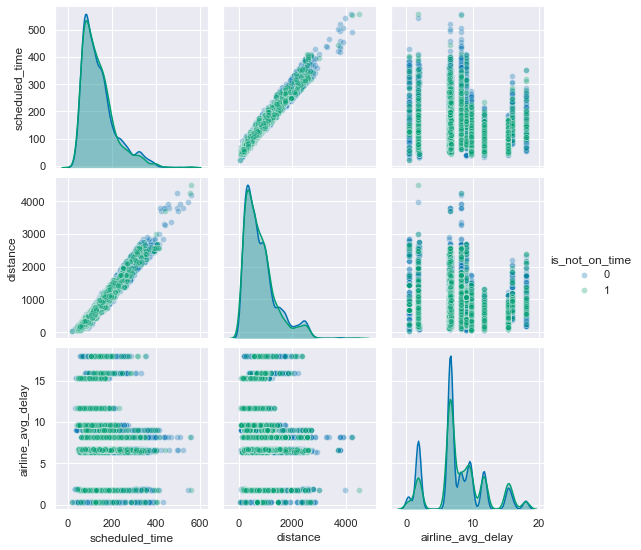

In [175]:
pairplot_features(sample_df[['scheduled_time', 'distance', 'airline_avg_delay', 'is_not_on_time']])

In [81]:
def feature_target_selection(features, target, df):
    """Returns two dataframes, each corresponding to the features and target.

    Args:
        features: A list of features for the model.
        target: The target for the model, passed as a single-element list.

    Returns:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting ot the target.
    """
    X = df.loc[:, features]
    y = df[target]
    return X, y

In [82]:
def initial_split(X, y):
    """Splits features and target dataframes in 80/20 ratio.

    Args:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting of the target.

    Returns:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        X_test: A dataframe, containing 20% of the original features data, to be
            used for testing.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        y_test: A dataframe, containing 20% of the original target data, to be
            used for testing.
    """
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4444)
    return X_train_val, X_test, y_train_val, y_test

In [111]:
def second_split(X_train_val, y_train_val):
    """Splits features and target dataframes so training set
    is 60% of all data and validation set is 20% of all data.
    
    Args:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation. 
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)
    return X_train, X_val, y_train, y_val

In [134]:
def cv(model, X_train_val, y_train_val, cv_records):
    """Performs 5-fold cross validation and prints training and test scores.
    Also adds scores to cv_records, which is a list of dicts.

    Args:
        model: Model to perform cross validation on. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        cv_records: A list of dicts to record cross validation scores.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=4444)
    scores = cross_validate(model, X_train_val, y_train_val,
                            cv=kf, scoring=['f1', 'precision',
                                            'recall', 'accuracy'],
                            return_train_score=True)

    mean_train_f1 = np.mean(scores['train_f1'])
    mean_val_f1 = np.mean(scores['test_f1'])
    mean_train_precision = np.mean(scores['train_precision'])
    mean_val_precision = np.mean(scores['test_precision'])
    mean_train_recall = np.mean(scores['train_recall'])
    mean_val_recall = np.mean(scores['test_recall'])
    mean_train_accuracy = np.mean(scores['train_accuracy'])
    mean_val_accuracy = np.mean(scores['test_accuracy'])

    print(f'{"Mean train F1:": <20}', mean_train_f1)
    print(f'{"Mean val F1:": <20}', mean_val_f1)
    print(f'{"Mean train precision:": <20}', mean_train_precision)
    print(f'{"Mean val precision:": <20}', mean_val_precision)
    print(f'{"Mean train recall:": <20}', mean_train_recall)
    print(f'{"Mean val recall:": <20}', mean_val_recall)
    print(f'{"Mean train accuracy:": <20}', mean_train_accuracy)
    print(f'{"Mean val accuracy:": <20}', mean_val_accuracy)

    cv_records.append(record_cv(mean_train_f1, mean_val_f1,
                                mean_train_precision, mean_val_precision,
                                mean_train_recall, mean_val_recall,
                                mean_train_accuracy, mean_val_accuracy))

In [135]:
def record_cv(mean_train_f1, mean_val_f1,
              mean_train_precision, mean_val_precision,
              mean_train_recall, mean_val_recall,
              mean_train_accuracy, mean_val_accuracy):
    """Records cross validation scores with other record-keeping information
    in a dict.

    Args:
        mean_train_f1: The mean cross validation training F1 score.
        mean_val_f1: The mean cross validation validation F1 score.
        mean_train_precision: The mean cross validation training precision score.
        mean_val_precision: The mean cross validation validation precision score.
        mean_train_recall: The mean cross validation training recall score.
        mean_val_recall: The mean cross validation validation recall score.
        mean_train_accuracy: The mean cross validation training accuracy score.
        mean_val_accuracy: The mean cross validation validation accuracy score.

    Returns:
        cv_dict: A dict of cross valiation scores with other record-keeping
            information.
    """
    cv_dict = {}
    model = input("model: ")
    desc = input("iteration_desc: ")
    feature = input("feature_engineering: ")
    hyperparameter = input('hyperparameter_tuning: ')
    
    cv_dict['model'] = model
    cv_dict['iteration_desc'] = desc
    cv_dict['feature_engineering'] = feature
    cv_dict['hyperparameter_tuning'] = hyperparameter
    
    cv_dict['mean_train_f1'] = mean_train_f1
    cv_dict['mean_val_f1'] = mean_val_f1
    cv_dict['mean_train_precision'] = mean_train_precision
    cv_dict['mean_val_precision'] = mean_val_precision
    cv_dict['mean_train_recall'] = mean_train_recall
    cv_dict['mean_val_recall'] = mean_val_recall
    cv_dict['mean_train_accuracy'] = mean_train_accuracy
    cv_dict['mean_val_accuracy'] = mean_val_accuracy
    
    return cv_dict

In [114]:
def plot_ROC(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    model_name = re.sub(r'\((.*)\)', '', str(model))
    plt.plot(fpr, tpr, lw=2, label=model_name)
    plt.plot([0,1], [0,1], c='violet', ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curves');
    plt.legend()
    return fpr, tpr, thresholds

In [92]:
X, y = feature_target_selection(['scheduled_time', 'distance'], 
                                'is_not_on_time', sample_df)

In [93]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: is_not_on_time, Length: 100000, dtype: int64

In [112]:
X_train_val, X_test, y_train_val, y_test = initial_split(X, y)
X_train, X_val, y_train, y_val = second_split(X_train_val, y_train_val)

In [177]:
with open('cv_records.pickle', 'wb') as to_write:
    pickle.dump(cv_records, to_write)

In [133]:
cv_records = []

In [131]:
def get_best_threshold_from_roc_curve(fpr, tpr, thresholds):
    """Returns best combined tpr/fpr score and the threshold associated with that score.
    
    Args:
        fpr: False positive rates (fp/(fp+tn)).
        tpr: True positive rates (tp/tp+fn).
    
    Returns:
        best_score: Highest combined tpr/fpr score (tpr - fpr).
        best_threshold: Threshold that corresponds to best_score.
        """
    combined_score = tpr - fpr
    best_threshold = thresholds[np.argmax(combined_score)]
    best_score = np.amax(combined_score)
    return best_score, best_threshold    

In [130]:
get_best_threshold_from_roc_curve(fpr, tpr, thresholds)

(0.026272530524377502, 0.15941774121322402)

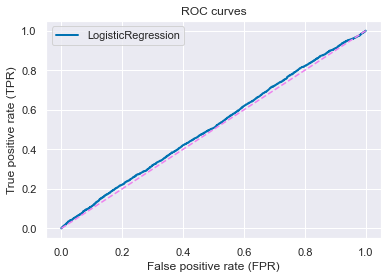

In [132]:
fpr, tpr, thresholds = plot_ROC(lm, X_train, X_val, y_train, y_val)

(7734,)

In [113]:
y_train_val.value_counts()

0    66615
1    13385
Name: is_not_on_time, dtype: int64

In [96]:
lm = LogisticRegression(penalty='none')
lm.fit(X_train_val, y_train_val)

LogisticRegression(penalty='none')

In [136]:
cv(lm, X_train_val, y_train_val, cv_records)

/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/m

Mean train F1:       0.0
Mean val F1:         0.0
Mean train precision: 0.0
Mean val precision:  0.0
Mean train recall:   0.0
Mean val recall:     0.0
Mean train accuracy: 0.8326874999999999
Mean val accuracy:   0.8326875000000001
model: logistic
iteration_desc: baseline
feature_engineering: 
hyperparameter_tuning: 


In [137]:
cv_records

[{'model': 'logistic',
  'iteration_desc': 'baseline',
  'feature_engineering': '',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8326874999999999,
  'mean_val_accuracy': 0.8326875000000001}]

In [105]:
lm.classes_

array([0, 1])

In [138]:
lm.predict(X_train_val)

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
lm.predict_proba(X_train_val)

array([[0.83407039, 0.16592961],
       [0.84587274, 0.15412726],
       [0.84413201, 0.15586799],
       ...,
       [0.82789742, 0.17210258],
       [0.83081209, 0.16918791],
       [0.83882036, 0.16117964]])

In [103]:
confusion = confusion_matrix(y_train_val, lm.predict(X_train_val))

In [104]:
confusion

array([[66615,     0],
       [13385,     0]])

In [100]:
kf = KFold(n_splits=5, shuffle=True, random_state=4444)
scores = cross_validate(lm, X_train_val, y_train_val,
                        cv=kf, scoring=['f1', 'accuracy', 'precision', 'recall'], 
                        return_train_score=True)

/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/m

In [101]:
scores

{'fit_time': array([0.14257526, 0.10968685, 0.12159419, 0.11793518, 0.12021112]),
 'score_time': array([0.0162456 , 0.01396918, 0.01376677, 0.01410699, 0.01309299]),
 'test_f1': array([0., 0., 0., 0., 0.]),
 'train_f1': array([0., 0., 0., 0., 0.]),
 'test_accuracy': array([0.8280625, 0.8376875, 0.8265   , 0.8390625, 0.832125 ]),
 'train_accuracy': array([0.83384375, 0.8314375 , 0.83423437, 0.83109375, 0.83282813]),
 'test_precision': array([0., 0., 0., 0., 0.]),
 'train_precision': array([0., 0., 0., 0., 0.]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'train_recall': array([0., 0., 0., 0., 0.])}